## Import các thư viện cần thiết

In [1]:
# Nhập thư viện cần thiết
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
from PIL import Image
import hashlib
from tensorflow.keras.optimizers import Adam


2024-05-20 03:56:33.721518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 03:56:33.721631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 03:56:33.850556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1. ## Tăng cường dữ liệu với các phương pháp:
* Lật, xoay ảnh 
* Tăng giảm độ sáng của hình ảnh
* Làm mờ ảnh bằng cách sử dụng median blur
* Tăng độ nét của ảnh bằng bộ lọc kernel

In [2]:
# Ham trich xuat dac trung 
def extract_features(image_path):
    image = cv2.imread(image_path, 0)
    if image is None:
        print(f"Could not read image: {image_path}")
        return None  

    # Lật, xoay ảnh 
    image_flipped = cv2.flip(image, 1)
    
    image_flipped_vertical = cv2.flip(image, 0)
    
    image_rotated_left = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    image_rotated_right = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    
    (h, w) = image.shape[:2]  
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, 20, 1.0)  # Tạo ma trận xoay
    image_rotated = cv2.warpAffine(image, M, (w, h)) # Tạo ảnh xoay 20 độ
    
    # Tăng độ sáng của ảnh
    image_brightness_increase = cv2.convertScaleAbs(image, alpha=1.2, beta=50)
    
    # Giảm độ sáng của ảnh
    image_brightness_decrease = cv2.convertScaleAbs(image, alpha=0.6, beta=-40)
    
    # Làm mờ ảnh 
    image_blur = cv2.medianBlur(image, 25)
    # Tăng độ nét 
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    image_sharp = cv2.filter2D(image, -1, kernel)

    # Resize về (224,224) và làm phẳng ảnh
    features_original = cv2.resize(image, (224, 224)).flatten()
    features_flipped = cv2.resize(image_flipped, (224, 224)).flatten()
    features_flipped_vertical = cv2.resize(image_flipped_vertical, (224, 224)).flatten()
    features_rotated_left = cv2.resize(image_rotated_left, (224, 224)).flatten()
    features_rotated_right = cv2.resize(image_rotated_right, (224, 224)).flatten()
    features_rotated = cv2.resize(image_rotated, (224, 224)).flatten()
    features_brightness_increase = cv2.resize(image_brightness_increase, (224, 224)).flatten()
    features_brightness_decrease = cv2.resize(image_brightness_decrease, (224, 224)).flatten()
    features_blur = cv2.resize(image_blur, (224, 224)).flatten()
    features_sharp = cv2.resize(image_sharp, (224, 224)).flatten()

    # Trả về danh sách các đặc trưng 
    return [features_original, features_rotated_left, features_rotated_right, features_rotated, features_brightness_increase, features_brightness_decrease, features_blur, features_sharp]


## Đọc dữ liệu nhãn từ tập tin CSV và trích xuất đặc trưng từ hình ảnh.
- lấy nhãn hình ảnh trong 'labels.csv'
- trich xuất các đặt trưng của ảnh sau khi tăng cường dữ liệu

In [3]:
import pandas as pd
import os
import numpy as np

# Đọc label trong file .csv 
labels_df = pd.read_csv('/kaggle/input/dataset/wb_2D3Dretrieval_dataset/labels.csv')

features = []
labels = []

image_files = os.listdir('/kaggle/input/dataset/wb_2D3Dretrieval_dataset/pairs/print')

# Lặp qua từng dòng trong DataFrame chứa dữ liệu nhãn
for index, row in labels_df.iterrows():
    # Lấy tên ảnh và nhãn từ mỗi dòng, 'query' là cột chứa tên ảnh, 'label' là cột chứa nhãn
    image_name = row['query']
    label = row['label'].split(',')[0]  # Lấy nhãn đầu tiên nếu có nhiều nhãn, phân cách bởi dấu phẩy

    # Kiểm tra xem tên ảnh có trong danh sách tên tệp ảnh không
    if image_name in image_files:
        # Xây dựng đường dẫn tới ảnh dựa trên tên ảnh
        image_path = os.path.join('/kaggle/input/dataset/wb_2D3Dretrieval_dataset/pairs/print', image_name)

        # Gọi hàm trích xuất đặc trưng từ ảnh tại đường dẫn đã xác định
        image_features = extract_features(image_path)

        # Thêm các đặc trưng trích xuất và nhãn tương ứng vào danh sách
        for feature in image_features:
            features.append(feature)
            labels.append(label)

# Chuyển đổi danh sách các đặc trưng và nhãn thành mảng NumPy để thuận tiện cho việc xử lý dữ liệu sau này
features = np.array(features)
labels = np.array(labels)


## Hiển thị ảnh sau khi tăng cường dữ liệu 

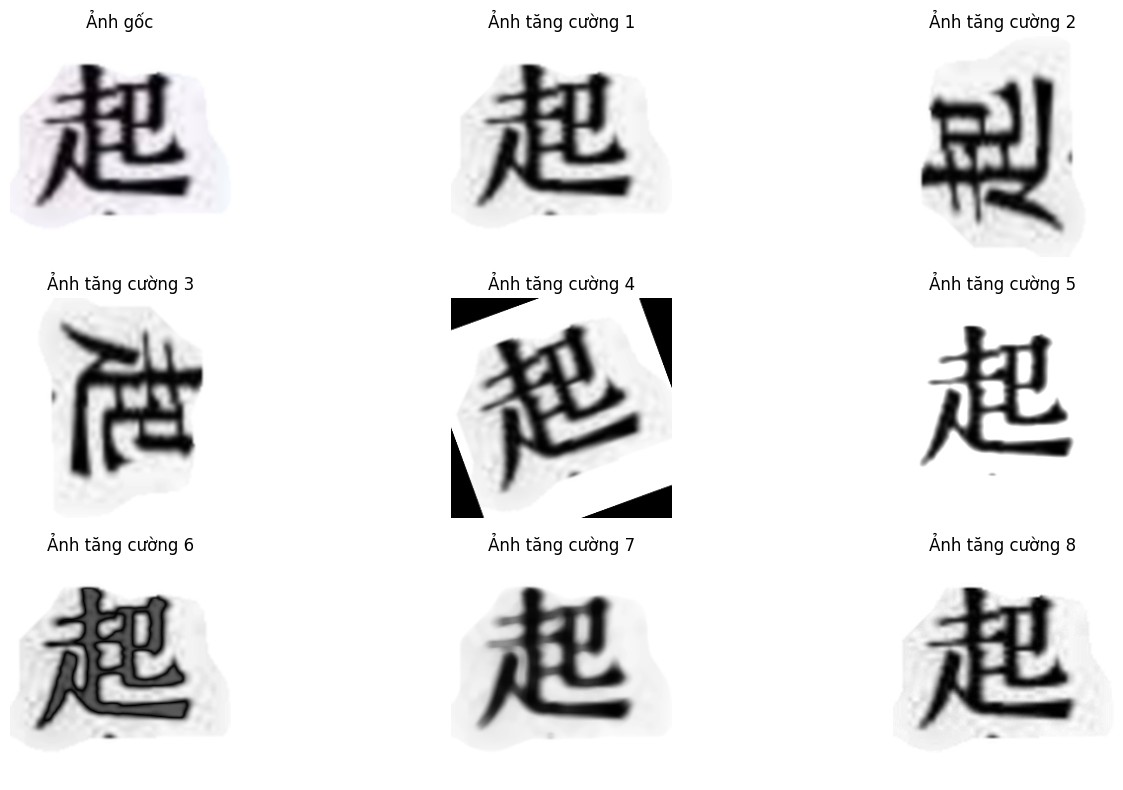

In [4]:
# Ví dụ ảnh 0.png sau khi tăng cường 
first_image_path = os.path.join('/kaggle/input/dataset/wb_2D3Dretrieval_dataset/pairs/print', labels_df['query'].iloc[0])


original_image = cv2.imread(first_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Chuyển đổi từ BGR sang RGB


image_features = extract_features(first_image_path)

# Xử lý đặc trưng và chuyển đổi về ảnh
augmented_images = []
for feature in image_features:
    image = feature.reshape(224, 224)
    augmented_images.append(image)

# Hiển thị các ảnh gốc và ảnh tăng cường
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
axes = axes.flatten()

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Ảnh gốc')
axes[0].axis('off')

for i, augmented_image in enumerate(augmented_images, start=1):
    axes[i].imshow(augmented_image, cmap='gray')
    axes[i].set_title(f'Ảnh tăng cường {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Chia tập dữ liệu sau khi tăng cường thành thành tập huấn luyện và kiểm tra
- 80% train
- 20% test

In [5]:
#Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Chuẩn hóa dữ liệu cho mô hình: điều chỉnh kích thước và chuyển đổi nhãn thành dạng số nguyên.

In [6]:

X_train = X_train.reshape(X_train.shape[0], 224, 224, 1)
X_test = X_test.reshape(X_test.shape[0], 224, 224, 1)

# Chuyển đổi label sang int
label_to_int = {label: i for i, label in enumerate(np.unique(labels))}
y_train = np.array([label_to_int[label] for label in y_train])
y_test = np.array([label_to_int[label] for label in y_test])

## Xây dựng mô hình CNN để phân loại hình ảnh.

In [7]:

# Xây dựng mô hình CNN
model = models.Sequential([
    layers.Conv2D(64, (2, 2), activation='relu', input_shape=(224, 224, 1), padding = 'same'),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(64, (2, 2), activation='relu', padding = 'same'),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(196, (2, 2), activation='relu', padding = 'same'),
    layers.MaxPooling2D((3, 3)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(228, activation='softmax')  
])

model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 196)    │        50,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 228)            │     2,860,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,927,400 (11.17 MB)

 Trainable params: 2,927,400 (11.17 MB)

 Non-trainable params: 0 (0.00 B)

## Biên dịch mô hình 

In [8]:

model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='sparse_categorical_crossentropy',  # Sử dụng sparse categorical crossentropy cho bài toán phân loại đa nhãn
              metrics=['accuracy'])


## Huấn luyện mô hình

In [9]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=15, batch_size=48, validation_data=(X_test, y_test))

Epoch 1/15
 2/31 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.0000e+00 - loss: 46.5390

I0000 00:00:1716177421.297806      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716177421.317116      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.0031 - loss: 33.8929

W0000 00:00:1716177427.182445      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716177427.842464      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.0031 - loss: 33.6920 - val_accuracy: 0.0082 - val_loss: 11.6479
Epoch 2/15
 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0000e+00 - loss: 19.5055

W0000 00:00:1716177429.567997      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0027 - loss: 18.0867 - val_accuracy: 0.0055 - val_loss: 7.9438
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0101 - loss: 12.1419 - val_accuracy: 0.0082 - val_loss: 6.6877
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0178 - loss: 9.2398 - val_accuracy: 0.0329 - val_loss: 6.0606
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0304 - loss: 7.1181 - val_accuracy: 0.1178 - val_loss: 5.3771
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0911 - loss: 5.3713 - val_accuracy: 0.2438 - val_loss: 4.9200
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1662 - loss: 4.4054 - val_accuracy: 0.3452 - val_loss: 4.5935
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3521 - loss: 3.3172 - val_accuracy: 0.4548 - val_loss: 4.2533
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4886 - loss: 2.6335 - val_accuracy: 0.5507 - val_loss: 

## Biểu đồ thể hiện các giá trị sau khi train

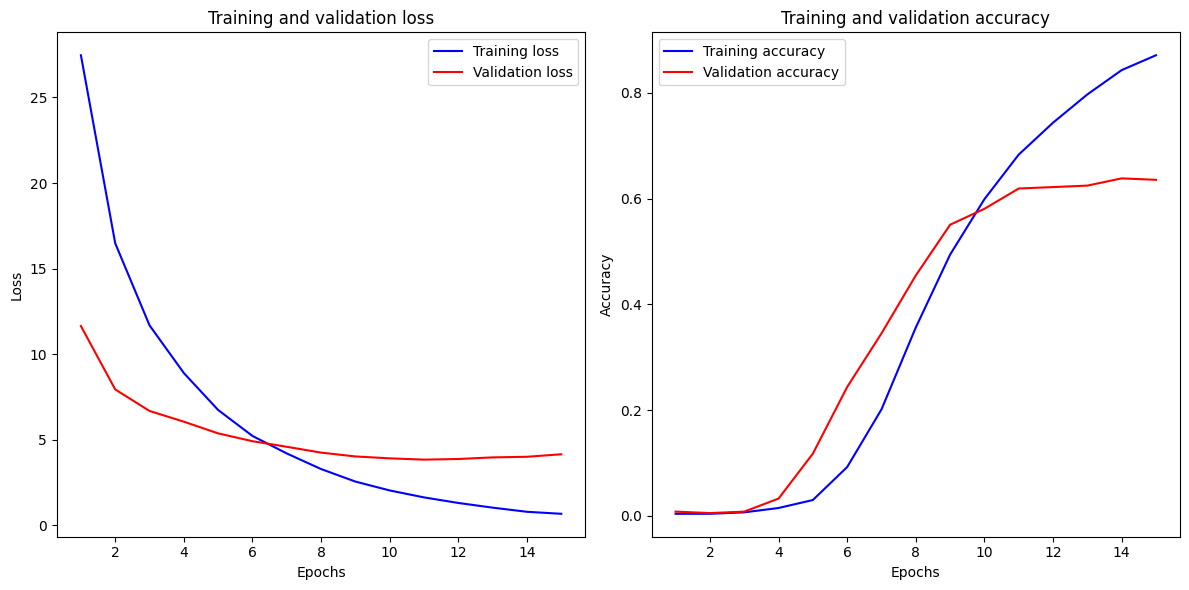

In [10]:
import matplotlib.pyplot as plt

# Lấy thông tin lịch sử huấn luyện
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Vẽ biểu đồ loss và accuracy trên cùng một hàng
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Đánh giá mô hình trên tập test

In [11]:

test_loss, test_acc = model.evaluate(X_test, y_test)

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6224 - loss: 4.0759

W0000 00:00:1716177452.557738      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.6284 - loss: 4.1006


W0000 00:00:1716177453.795555      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Lưu mô hình

In [12]:
model.save('/kaggle/working/saved_model.h5')

## Dự đoán cho tất cả ảnh trong thư mục

In [13]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# Đọc model 
model = load_model('/kaggle/working/saved_model.h5')

def extract_features(image_path):
    # Đọc ảnh và chuyển đổi sang ảnh xám
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize ảnh 
    image = cv2.resize(image, (224, 224))
    image = np.array(image).reshape(-1, 224, 224, 1)
    return image

def predict_image(image_path, model):
    # Trích xuất đặc trưng từ ảnh
    image_features = extract_features(image_path)
    if image_features is None:
        print("Lỗi xử lý ảnh.")
        return None
    # Sử dụng mô hình đã huấn luyện để dự đoán
    prediction = model.predict(image_features)
    # Lấy ra 5 nhãn có xác suất dự đoán cao nhất
    top5_indices = np.argsort(prediction[0])[::-1][:5]
    # Chuyển đổi các chỉ số dự đoán thành nhãn
    int_to_label = {i: label for label, i in label_to_int.items()}
    top5_labels = [int_to_label[index] for index in top5_indices]
    # Lấy ra xác suất dự đoán của 5 nhãn đó
    top5_probs = prediction[0][top5_indices]
    return top5_labels, top5_probs

# Path to predict image folder
image_folder = '/kaggle/input/dataset/wb_2D3Dretrieval_dataset/pairs/print'

## Thực hiện ghi nhãn tên ảnh và nhãn dự đoán tương ứng vào file csv

In [14]:
import csv

csv_file = '/kaggle/working/ouput.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image', 'labels'])  

    # Duyệt qua mỗi file trong thư mục và gắn nhãn dự đoán 
    image_names = sorted(os.listdir(image_folder))
    for image_name in image_names:
        image_path = os.path.join(image_folder, image_name)
        if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Chỉ xử lý file ảnh
            top5_labels, _ = predict_image(image_path, model)
            predicted_labels = ', '.join(top5_labels)
            writer.writerow([image_name, predicted_labels])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━